## Análisis de la estructura de datos - Sujeto 2:

In [1]:
import os
import os.path
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar

import mne
import mne.io
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.datasets import somato
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch

from scipy import signal
from TFG_utils import extract_files
from TFG_utils import take_vmrk_filename
from TFG_utils import take_vhdr_filename
from TFG_utils import take_eeg_filename
from TFG_utils import get_dep_channel
from TFG_utils import get_dep_channel_bandas
from TFG_utils import get_ratio

# FOOOF imports
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg

%matplotlib notebook


El [formato de BrainVision](https://mne.tools/dev/auto_tutorials/io/plot_20_reading_eeg_data.html#brainvision-vhdr-vmrk-eeg) tiene una estructura divivida en los tres siguientes ficheros:

* La **cabecera (.vhdr)** del fichero  con los metadatos.

* Un archivo de **marcadores (.vmrk)** del texto con información sobre los eventos.

* Un archivo de **datos binarios (.eeg)** que contiene el valor de los voltajes del EEG.

In [2]:
folder = "Pruebas 1611/Sujeto-2" # Nombre de la carpeta.
files = extract_files(folder) # Función leer path.
print('Existen', len(files), 'ficheros en la carpeta',folder, ':')

vmrk_filename = take_vmrk_filename(folder) # Leer nombre de archivo con extensión vmrk
vhdr_filename = take_vhdr_filename(folder) # Leer nombre de archivo con extensión vhdr
eeg_filename = take_eeg_filename(folder) # Leer nombre de archivo con extensión eeg

print('\n',eeg_filename,'\n',vhdr_filename,'\n',vmrk_filename,'\n')

Existen 3 ficheros en la carpeta Pruebas 1611/Sujeto-2 :

 Pruebas 1611/Sujeto-2\TFG_MartaCastejon-0002.eeg 
 Pruebas 1611/Sujeto-2\TFG_MartaCastejon-0002.vhdr 
 Pruebas 1611/Sujeto-2\TFG_MartaCastejon-0002.vmrk 



Los datos de BrainVision pueden leerse con la [función mne.io.read_raw_brainvision()](https://mne.tools/dev/generated/mne.io.read_raw_brainvision.html#mne.io.read_raw_brainvision) con el fichero de cabecera (.vhdr) como input. Con esta función se obtiene un objeto en formato Raw que contiene todos los datos del fichero .eeg BrainVision. Con el [método get_data()](https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw) se extraen los datos del objeto Raw en microvoltios.

In [3]:
#Lectura señal .vhdr
eeg_object = mne.io.read_raw_brainvision(vhdr_filename).load_data(verbose=True)

Extracting parameters from Pruebas 1611/Sujeto-2\TFG_MartaCastejon-0002.vhdr...
Setting channel info structure...
Reading 0 ... 18289  =      0.000 ...    36.578 secs...


**EEG_OBJECT**

El objeto EEG contiene los datos del fichero **.eeg** y está formado por **31 canales** con **18.290 muestras** obtenidas en **36 segundos**.

In [4]:
eeg_object

<RawBrainVision | TFG_MartaCastejon-0002.eeg, 31 x 18290 (36.6 s), ~4.4 MB, data loaded>

Para el estudio de los datos se utilizarán [atributos](https://mne.tools/dev/auto_tutorials/raw/plot_10_raw_overview.html#the-raw-info-attribute) del objeto RAW como:
* **ch_names**: vector con el nombre de los canales
* **n_times**: número de muestras de tiempo
* **times**: vector con las muestras de tiempo
* **info**: información del objeto (nombre de los canales, número de canales, fecha, frecuencia..) 


In [5]:
print('Hay', len(eeg_object.ch_names),'canales:', eeg_object.ch_names)

Hay 31 canales: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']


In [6]:
print('Hay',eeg_object.n_times,'muestras de tiempo')

Hay 18290 muestras de tiempo


In [7]:
print('El vector de muestras de tiempo es:',eeg_object.times)

El vector de muestras de tiempo es: [0.0000e+00 2.0000e-03 4.0000e-03 ... 3.6574e+01 3.6576e+01 3.6578e+01]


In [8]:
info=eeg_object.info
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 31 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 140.0 Hz
 meas_date: 2020-11-16 18:31:30 UTC
 nchan: 31
 projs: []
 sfreq: 500.0 Hz
>


**EEG_DATA**

Para este sujeto, la señal ha tenido que ser recortada a 32 segundos

In [9]:
eeg_object.crop(tmin=0, tmax=32)
eeg_data = eeg_object.get_data() #Carga de datos de la señal recortada

In [10]:
num_canales = eeg_data.shape[0]
num_columnas = eeg_data.shape[1]
print('Hay', num_canales, 'filas y ', num_columnas, 'columnas')

Hay 31 filas y  16001 columnas


In [60]:
#Variables fijas
ch = 0 #canal de ejemplo para todas las gráficas específicas.
channel_labels = eeg_object.ch_names
Fs = info['sfreq'] # Frecuencia de muestreo

print(channel_labels)
print(Fs)

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
500.0


Representación de la señal original

In [61]:
#Remove the linear shift along the data axis.
eeg_data = signal.detrend(eeg_data)

<IPython.core.display.Javascript object>


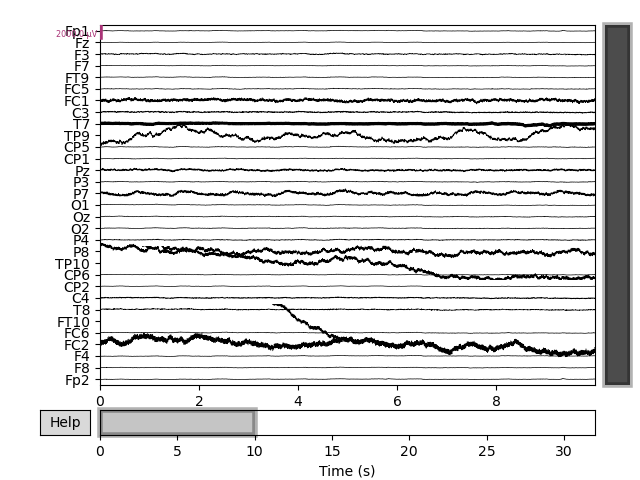

In [62]:
original_signal=[]

for i in range(num_canales):
    original_signal.append(eeg_data[i])
    
original_signal = mne.io.RawArray(original_signal, info,verbose=False).set_montage("standard_1020", verbose= False)

original_signal.plot(scalings={"eeg": 100e-5},title='Señal EEG Filtrada Paso Banda', n_channels=31, verbose=False)
plt.show()

Representación del canal de ejemplo de la señal original

<IPython.core.display.Javascript object>


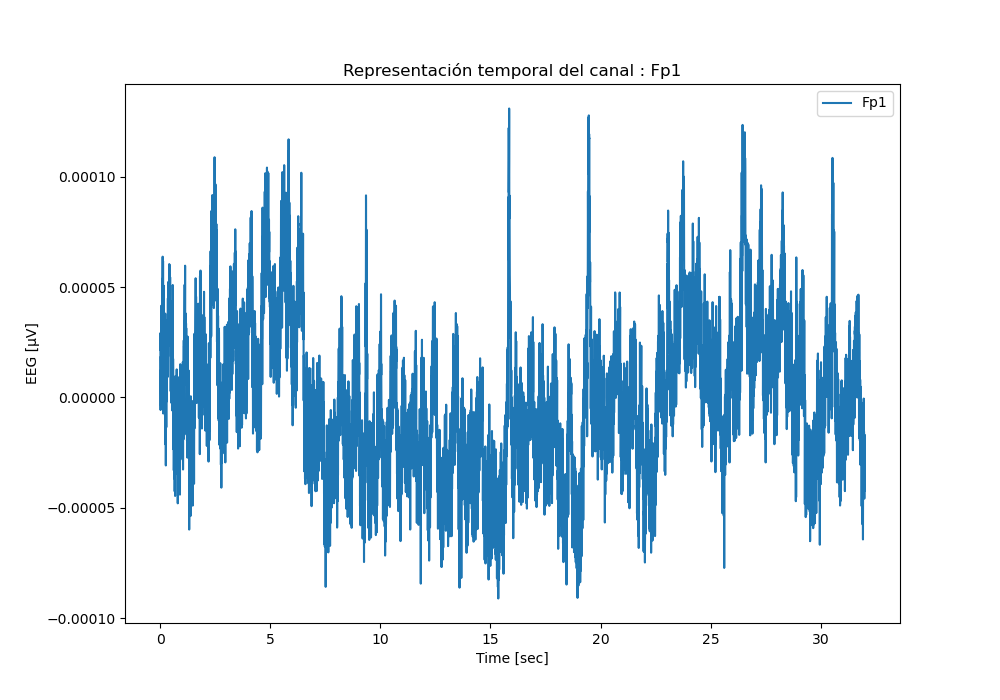

In [63]:
plt.figure(figsize=(10,7))

axx = eeg_object.times
axy = eeg_data[ch]
plt.plot(axx, axy, label=channel_labels[ch])

plt.title("Representación temporal del canal : "  + channel_labels[ch])
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

Representación del espectro del canal de ejemplo de la señal original.

<IPython.core.display.Javascript object>


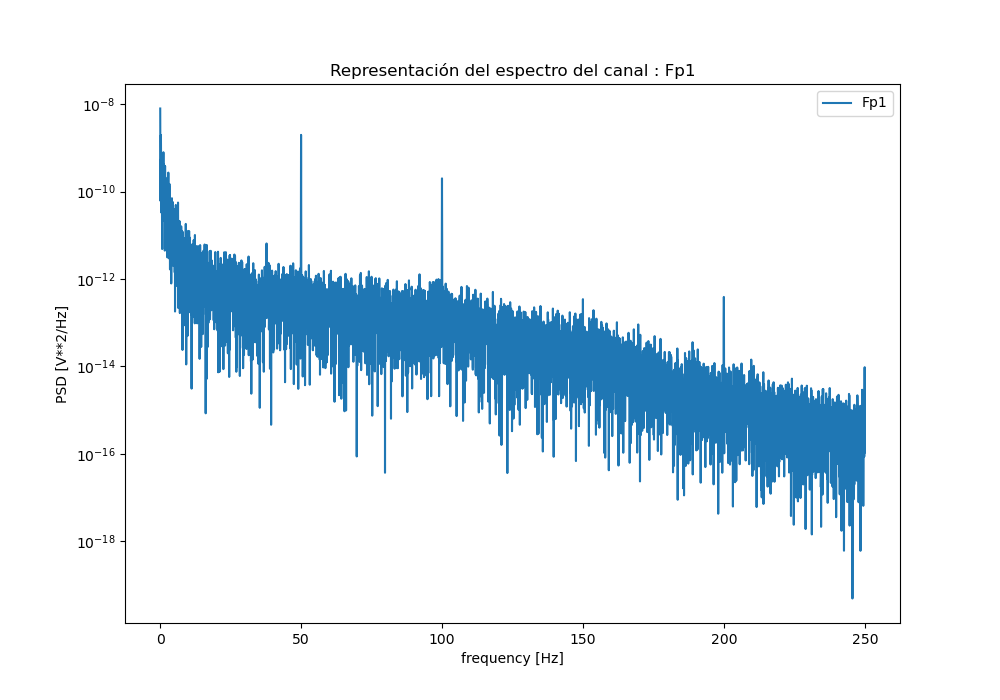

In [64]:
fig = plt.figure(figsize=(10,7))

potencia_por_canal, idx, f, Px = get_dep_channel(original_signal,Fs,ch)
plt.semilogy(f[idx],Px[idx],label=channel_labels[ch])

plt.title('Representación del espectro del canal : '  + channel_labels[ch])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(loc="best", ncol= 3)
plt.show()

Representación del espectro de la señal original de todos los canales.

<IPython.core.display.Javascript object>


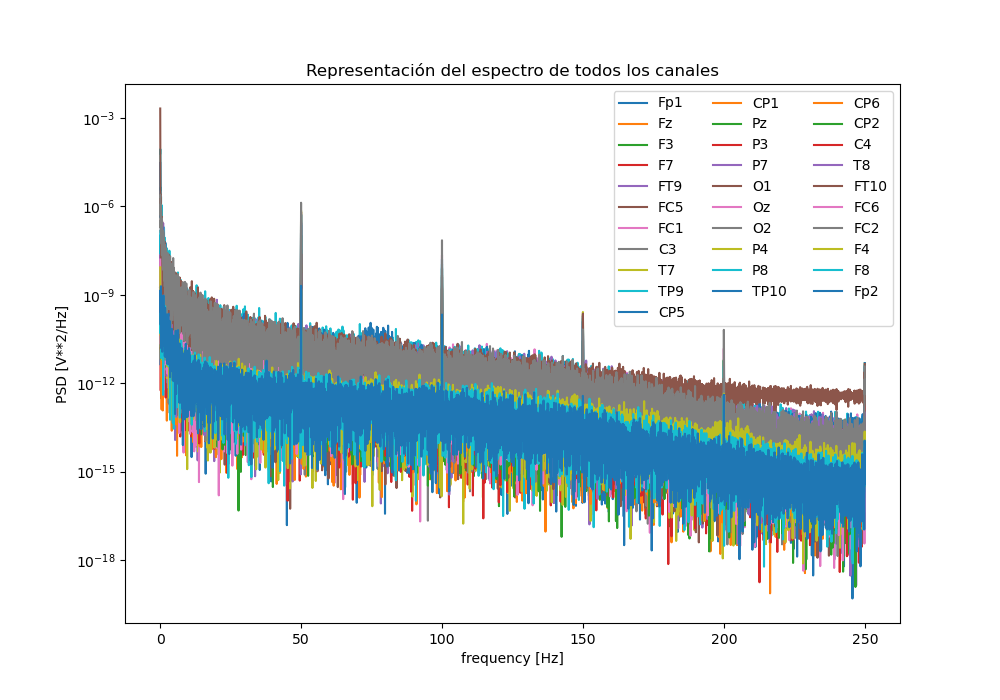

In [38]:
fig = plt.figure(figsize=(10,7))

i=0
while i<(num_canales):
    potencia_por_canal, idx, f, Px=get_dep_channel(original_signal,Fs,i)
    plt.semilogy(f[idx],Px[idx],label=channel_labels[i])
    i+=1

plt.title('Representación del espectro de todos los canales')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(loc="best", ncol= 3)
plt.show()

## Filtrado

### Filtrado paso banda (FIR)

In [17]:
#Fs
numtaps = 70 #longitud del filtro
f1 = 2 #límite de banda inferior
f2 = 42 #límite de banda superior

#b = signal.firwin(numtaps, cutoff,pass_zero(opcional), frec nyq)
b = signal.firwin(numtaps, [f1, f2], pass_zero=False, fs=Fs)

In [18]:
# Frequency response
w, h = signal.freqz(b, 1)
# Generate frequency axis
freq = w*Fs/(2*np.pi)

In [19]:
eeg_filter_bandpass = signal.filtfilt(b, 1, eeg_data)

<ipython-input-65-25ac8612dc06>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,7))


<IPython.core.display.Javascript object>


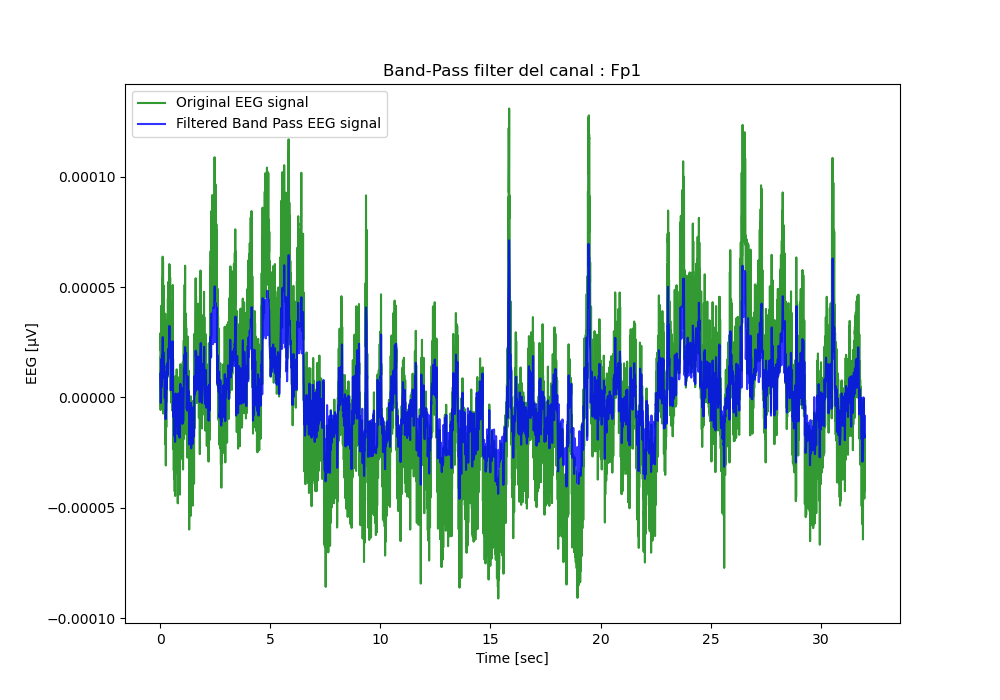

<IPython.core.display.Javascript object>


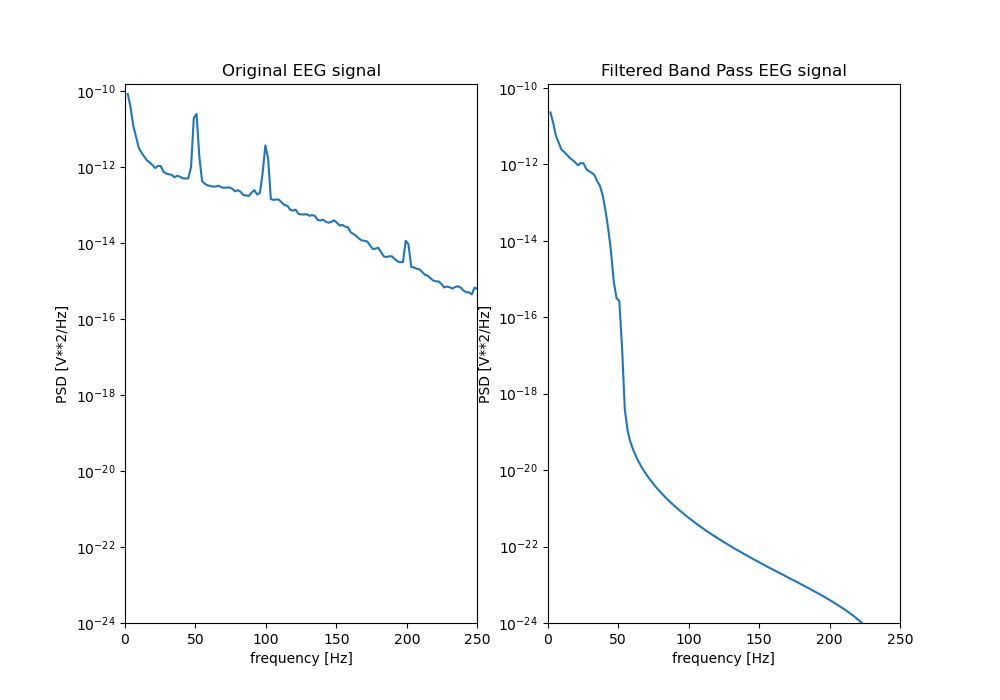

<ipython-input-65-25ac8612dc06>:38: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0.000000000000000000000001, 0])
<ipython-input-65-25ac8612dc06>:38: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0.000000000000000000000001, 0])


<IPython.core.display.Javascript object>


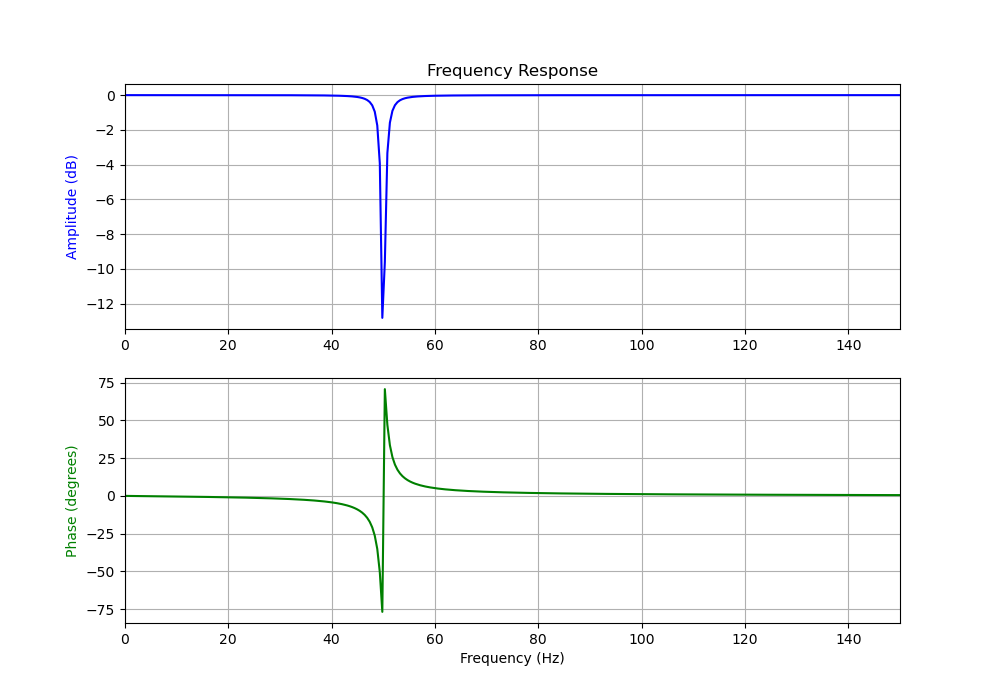

In [65]:
labels = ['Original EEG signal','Filtered Band Pass EEG signal']

# EEG TIME PLOT
plt.figure(figsize=(10,7))

axx = eeg_object.times
axy1 = eeg_data[ch] #Original Signal
axy2 = eeg_filter_bandpass[ch] #Filtered Signal

plt.plot(axx, axy1, c='green', label=labels[0], alpha=0.8)
plt.plot(axx, axy2, c='blue', label=labels[1], alpha=0.8)

plt.title("Band-Pass filter del canal : "  + channel_labels[ch])
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

# EEG FREQ PLOT
sig_list=[eeg_data[ch], eeg_filter_bandpass[ch]]
fs=int(Fs)

cont=0
fig = plt.figure(figsize=(10,7))
for sig in sig_list:
    cont+=1
    f, Px = signal.welch(sig, fs, window='hann') 
    plt.subplot(1,len(sig_list),cont)
    idx = []
    for i in f:
        if i>0:
            idx.append(True)
        else:
            idx.append(False)
    plt.semilogy(f[idx],Px[idx])
    plt.title(labels[cont-1])
    plt.xlim([0, 250])
    plt.ylim([0.000000000000000000000001, 0])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

# FREQUENCY RESPONSE
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 150])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Phase (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 150])
ax[1].grid()

plt.show()

Representación temporal de todos los canales filtrados con Paso Banda

<IPython.core.display.Javascript object>


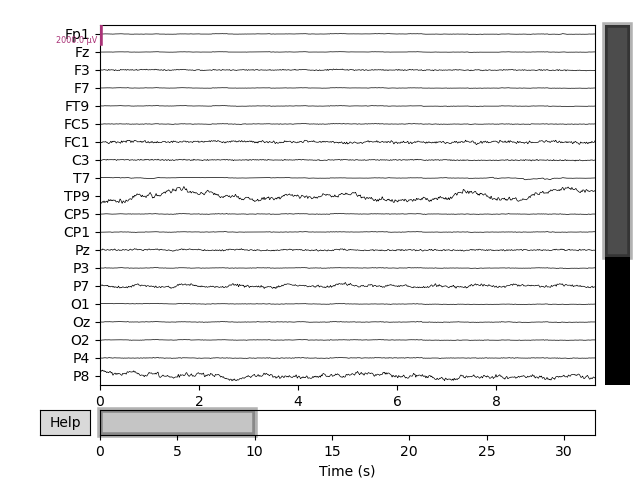

In [40]:
signal_filtered=[]

for i in range(num_canales):
    signal_filtered.append(eeg_filter_bandpass[i])
    
signal_filtered = mne.io.RawArray(signal_filtered, info,verbose=False).set_montage("standard_1020", verbose= False)

signal_filtered.plot(scalings={"eeg": 100e-5},title='Señal EEG Filtrada Paso Banda', n_channels=31, verbose=False)
plt.show()


Representación espectral de todos los canales de la señal original filtrados con Paso Banda

<IPython.core.display.Javascript object>


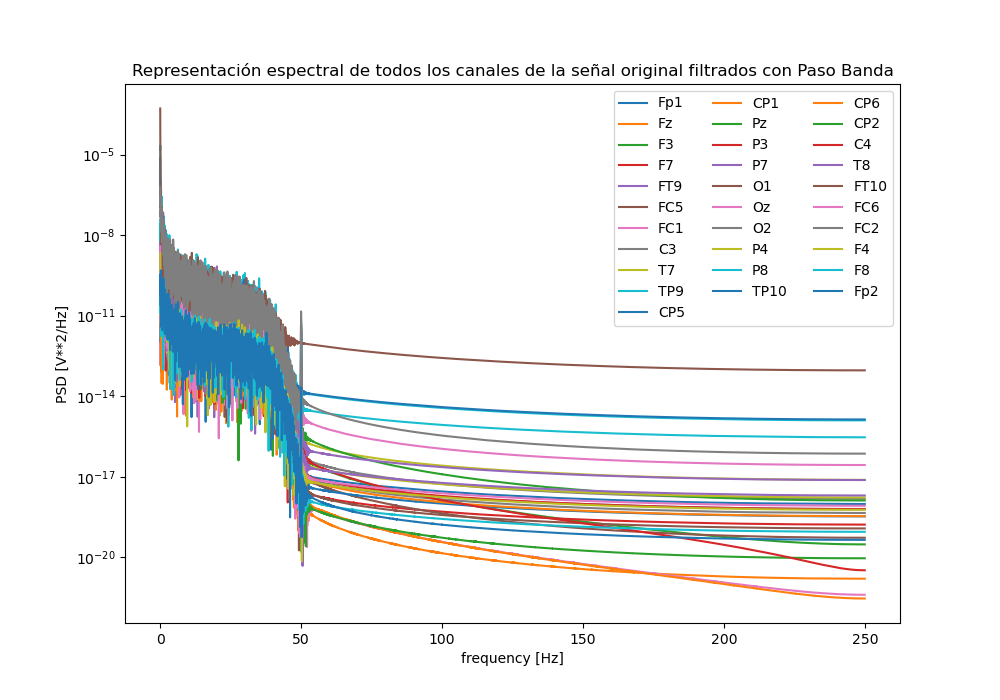

In [41]:
fig = plt.figure(figsize=(10,7))

i=0
while i<(num_canales):
    potencia_por_canal, idx, f, Px=get_dep_channel(signal_filtered,Fs,i)
    plt.semilogy(f[idx],Px[idx],label=channel_labels[i])
    i+=1

plt.title('Representación espectral de todos los canales de la señal original filtrados con Paso Banda')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(loc="best", ncol= 3)
plt.show()

<IPython.core.display.Javascript object>


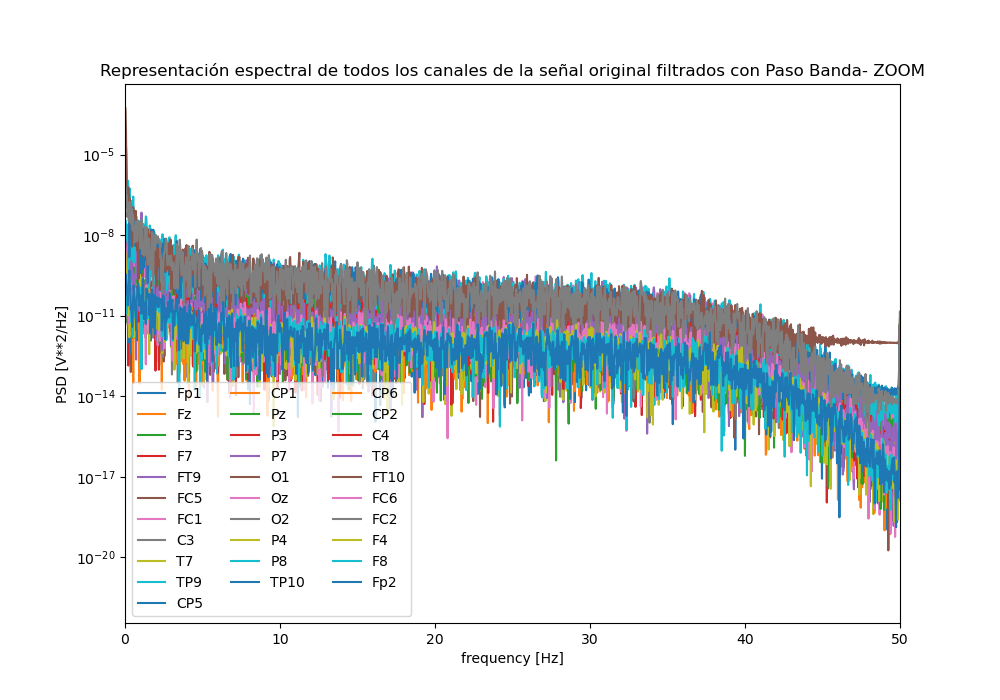

In [42]:
fig = plt.figure(figsize=(10,7))

i=0
while i<(num_canales):
    potencia_por_canal, idx, f, Px=get_dep_channel(signal_filtered,Fs,i)
    plt.semilogy(f[idx],Px[idx],label=channel_labels[i])
    i+=1


plt.title('Representación espectral de todos los canales de la señal original filtrados con Paso Banda- ZOOM')
plt.xlim([0, 50])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(loc="best", ncol= 3)
plt.show()

### Filtrado Notch

In [24]:
#Parameter for calculation of Filtering notch
#Fs
f0 = 50.0 # Frequency to be removed from signal (Hz)
Q = 30.0 # Quality factor
w0 = f0/(Fs/2)# Normalized Frequency

b,a = signal.iirnotch(w0,Q)

In [25]:
# Frequency response
w, h = signal.freqz(b, a)
# Generate frequency axis
freq = w*Fs/(2*np.pi)

<IPython.core.display.Javascript object>


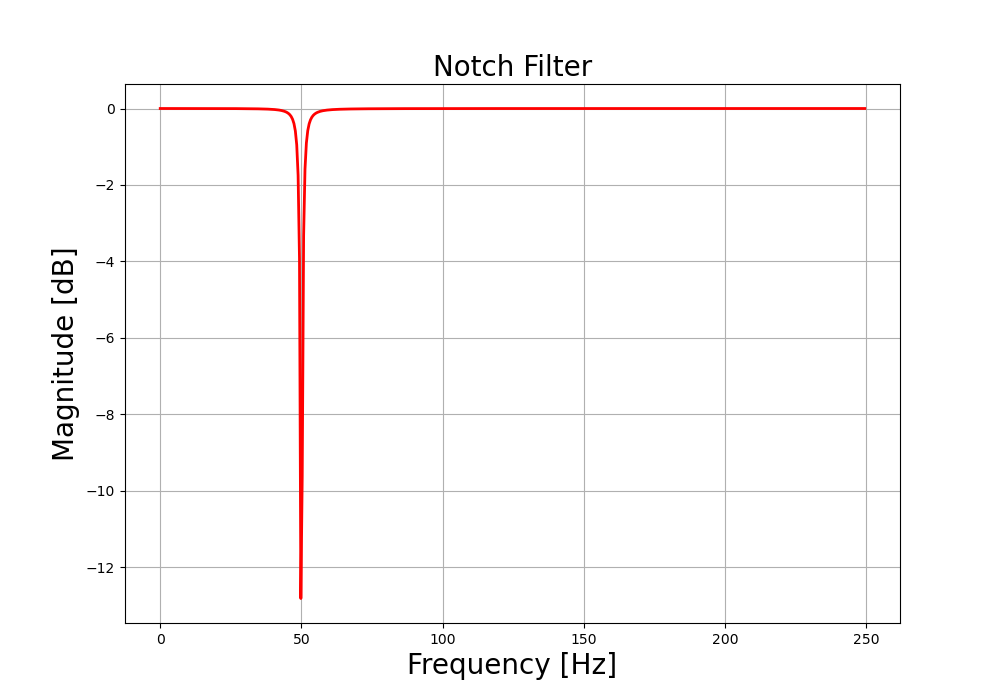

In [43]:
fig = plt.figure(figsize=(10, 7))
  
# Plot magnitude response of the filter
plt.plot(freq, 20 * np.log10(abs(h)),'r', label='Notch filter', linewidth='2')
  
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Magnitude [dB]', fontsize=20)
plt.title('Notch Filter', fontsize=20)
plt.grid()

In [44]:
eeg_filter_notch = signal.filtfilt(b,a,eeg_filter_bandpass) #Apply the Notch filter

<ipython-input-66-1a240ac82199>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,7))


<IPython.core.display.Javascript object>


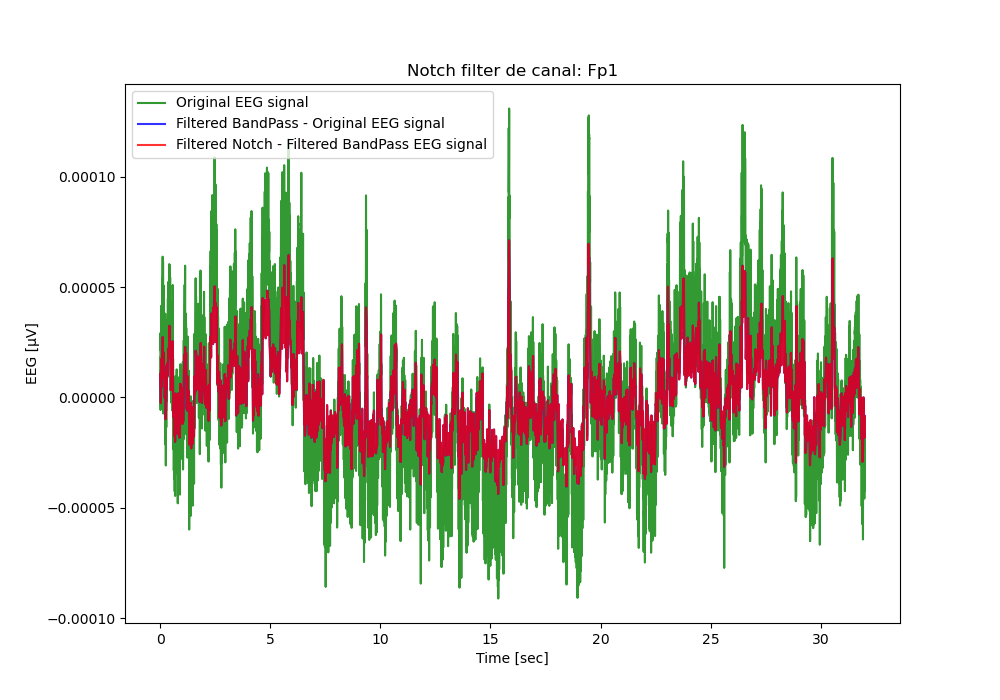

<IPython.core.display.Javascript object>


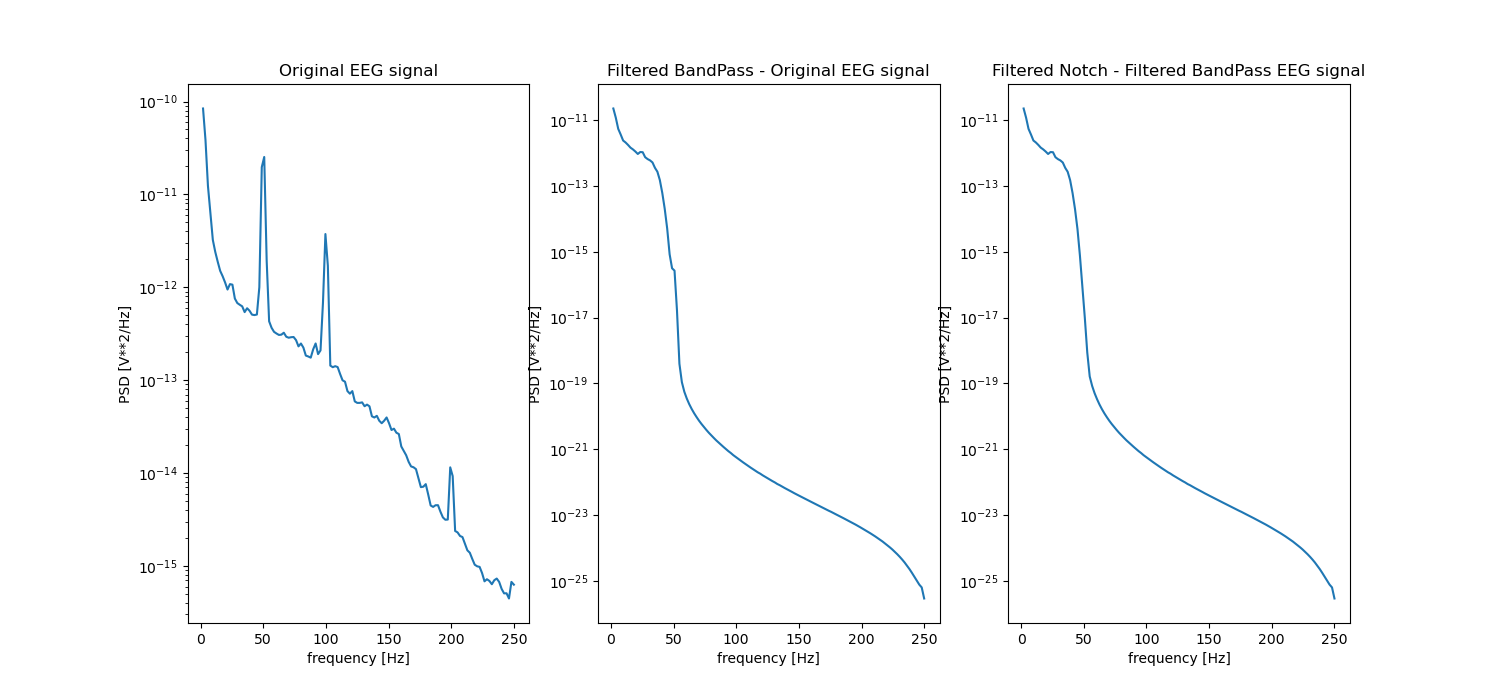

<IPython.core.display.Javascript object>


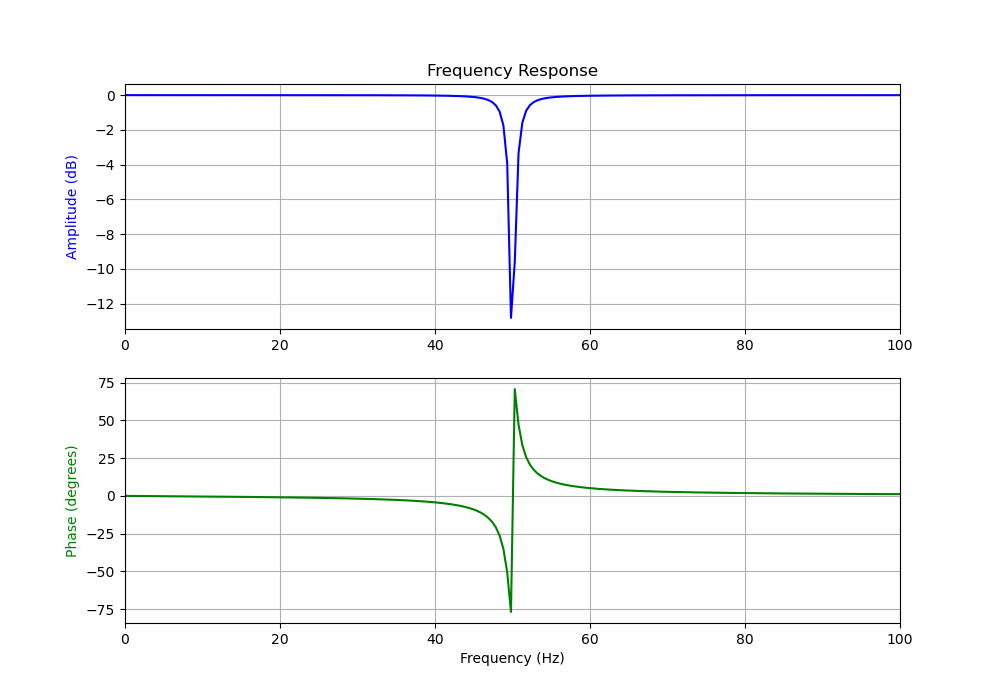

In [66]:
labels = ['Original EEG signal', 'Filtered BandPass - Original EEG signal', 'Filtered Notch - Filtered BandPass EEG signal']

# EEG TIME PLOT
plt.figure(figsize=(10,7))

axx = eeg_object.times
axy1 = eeg_data[ch]
axy2 = eeg_filter_bandpass[ch]
axy3 = eeg_filter_notch[ch]

plt.plot(axx, axy1, c='green', label=labels[0], alpha=0.8) #original signal
plt.plot(axx, axy2, c='blue', label=labels[1], alpha=0.8) #filtered BP signal
plt.plot(axx, axy3, c='red', label=labels[2], alpha=0.8) #filtered BP - Notch signal

plt.title("Notch filter de canal: "  + channel_labels[ch])
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

# EEG FREQ PLOT
sig_list=[eeg_data[ch], eeg_filter_bandpass[ch], eeg_filter_notch[ch]]
fs=int(Fs)

cont=0
fig = plt.figure(figsize=(15,7))
for sig in sig_list:
    cont+=1
    f, Px = signal.welch(sig, fs, window='hann') 
    plt.subplot(1,len(sig_list),cont)
    idx = []
    for i in f:
        if i>0:
            idx.append(True)
        else:
            idx.append(False)
    plt.semilogy(f[idx],Px[idx])
    plt.title(labels[cont-1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

# FREQUENCY RESPONSE

fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].plot(freq, 20 * np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Phase (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].grid()

plt.show()


Reperesentación temporal de la señal filtrada (BP + Notch)

<IPython.core.display.Javascript object>


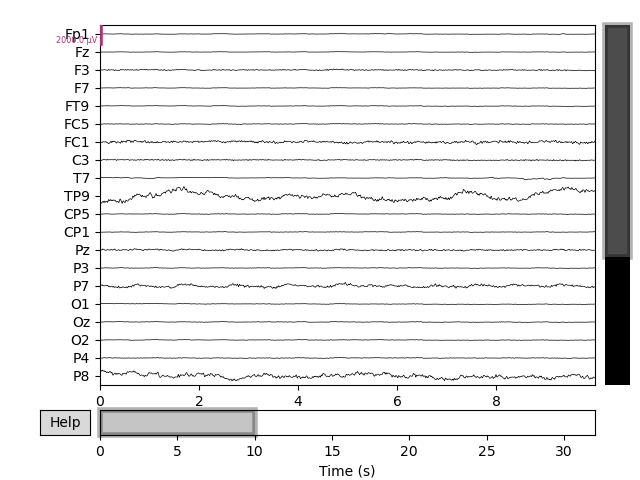

In [46]:
signal_filtered=[]

for ch in range(num_canales):
    signal_filtered.append(eeg_filter_notch[ch])
    
signal_filtered = mne.io.RawArray(signal_filtered, info,verbose=False).set_montage("standard_1020", verbose= False)

signal_filtered.plot(scalings={"eeg": 100e-5},title='Señal EEG Filtrada Paso Banda', n_channels=31, verbose=False)
plt.show()

Filtrado Notch para todos los canales

<IPython.core.display.Javascript object>


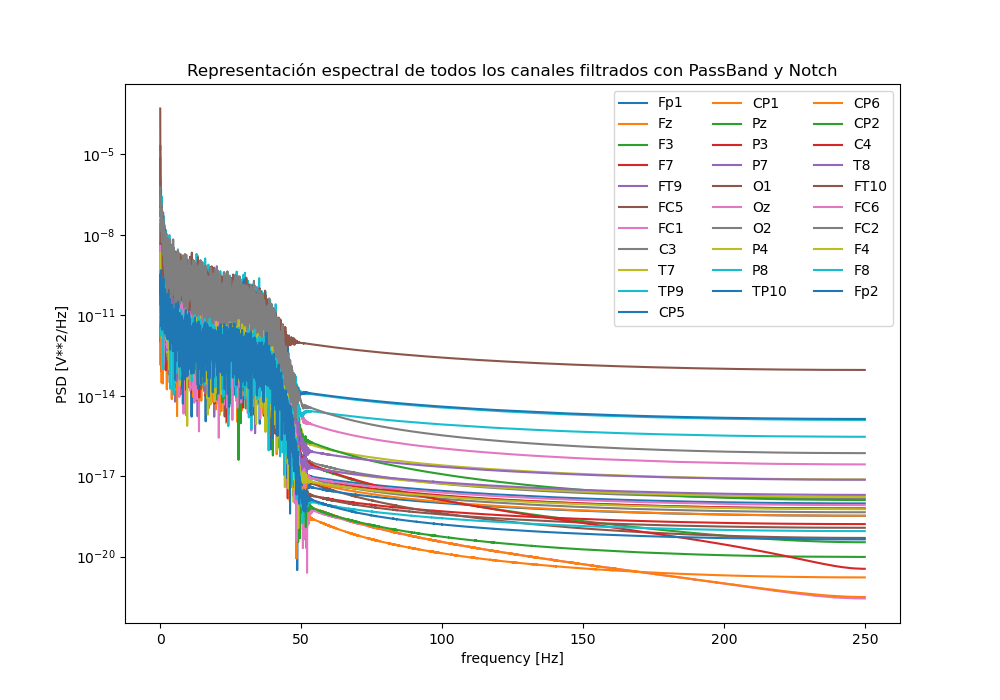

In [47]:
fig = plt.figure(figsize=(10,7))

i=0
while i<(num_canales):
    potencia_por_canal, idx, f, Px=get_dep_channel(signal_filtered,Fs,i)
    plt.semilogy(f[idx],Px[idx],label=channel_labels[i])
    i+=1

plt.title('Representación espectral de todos los canales filtrados con PassBand y Notch')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(loc="best", ncol= 3)
plt.show()

In [31]:
fig = plt.figure(figsize=(10,7))

i=0
while i<(num_canales):
    potencia_por_canal, idx, f, Px=get_dep_channel(signal_filtered,Fs,i)
    plt.semilogy(f[idx],Px[idx],label=channel_labels[i])
    i+=1


plt.title('Representación espectral de todos los canales filtrados con Notch - Zoom 50Hz')
plt.xlim([20, 80])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(loc="best", ncol= 3)
plt.show()

<IPython.core.display.Javascript object>

Filtrado ICA (Independent Component Analysis)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 31 components


<ipython-input-48-90cad99d7057>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  filtered_ica = mne.preprocessing.ICA(n_components=31, random_state=1, verbose=True).fit(signal_filtered)
<ipython-input-48-90cad99d7057>:1: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  filtered_ica = mne.preprocessing.ICA(n_components=31, random_state=1, verbose=True).fit(signal_filtered)


Fitting ICA took 4.0s.
Creating RawArray with float64 data, n_channels=31, n_times=16001
    Range : 0 ... 16000 =      0.000 ...    32.000 secs
Ready.


C:\Users\marta.castejon.SPAIN\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
<ipython-input-48-90cad99d7057>:1: RuntimeWarning: Using n_components=31 (resulting in n_components_=31) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 27
  filtered_ica = mne.preprocessing.ICA(n_components=31, random_state=1, verbose=True).fit(signal_filtered)


<IPython.core.display.Javascript object>


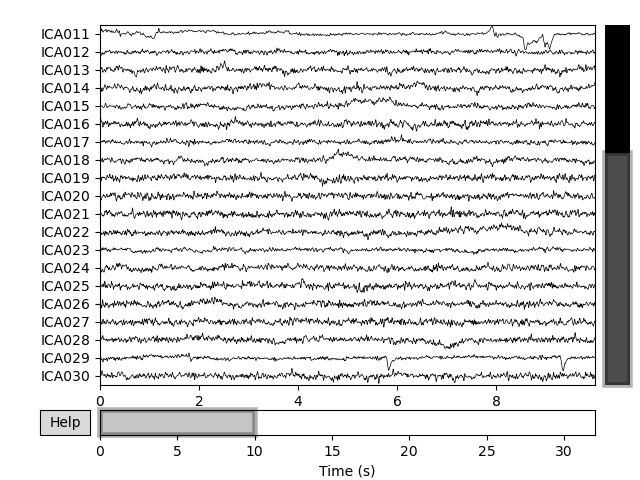

In [48]:
filtered_ica = mne.preprocessing.ICA(n_components=31, random_state=1, verbose=True).fit(signal_filtered)
filtered_ica.plot_sources(inst=signal_filtered, start=0, stop=10)
plt.show()

<IPython.core.display.Javascript object>


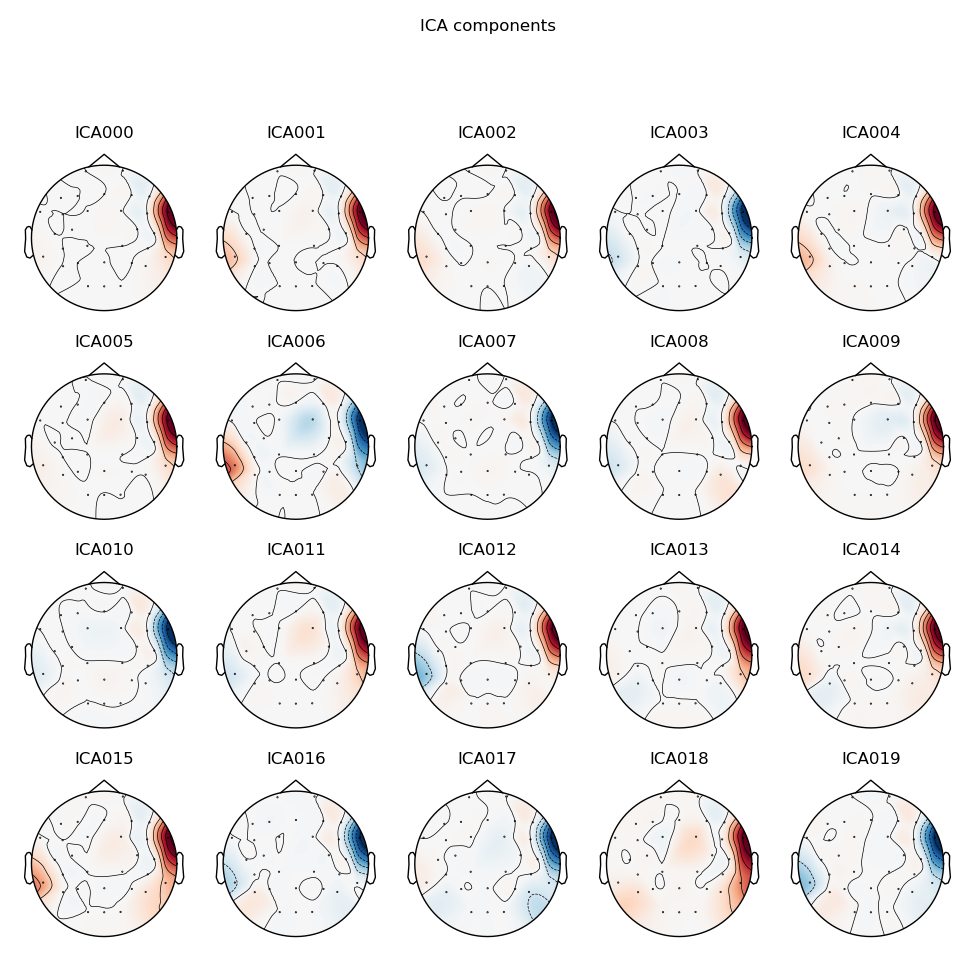

<IPython.core.display.Javascript object>


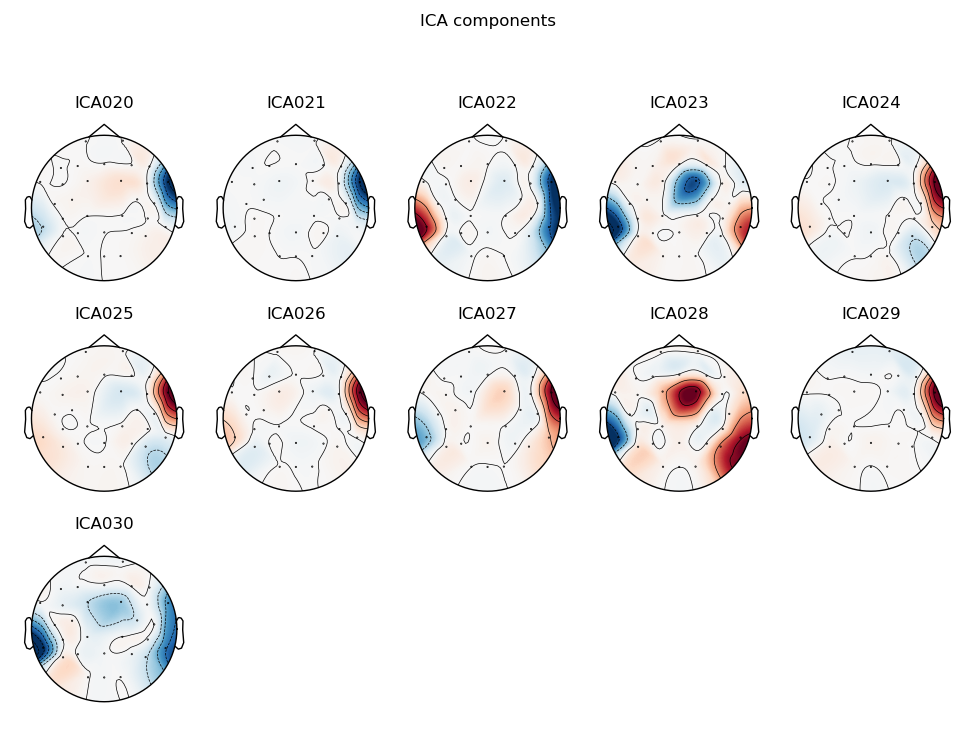

In [33]:
filtered_ica.plot_components()
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components


C:\Users\marta.castejon.SPAIN\Anaconda3\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


<IPython.core.display.Javascript object>


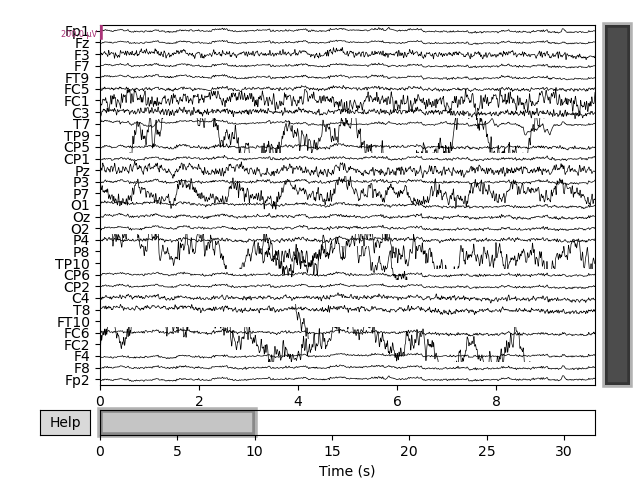

In [49]:
signal_filtered_corrected = signal_filtered.copy()
filtered_ica.apply(signal_filtered_corrected)
signal_filtered_corrected.plot(scalings={"eeg": 100e-6}, title='Signal after ICA', verbose=False, n_channels=31)
plt.show()

Frequency and time-frequency sensor analysis

In [50]:
# Set the reference to be average reference
signal_filtered_corrected = signal_filtered_corrected.set_eeg_reference()

In [ ]:
potencia_por_canal, potencia_banda_delta, potencia_banda_theta, potencia_banda_alpha, potencia_banda_beta, potencia_banda_gamma, f, Px = get_dep_channel_bandas(signal_filtered_corrected,Fs)

pot_bandas = [potencia_banda_delta, potencia_banda_theta, potencia_banda_alpha, potencia_banda_theta, potencia_banda_gamma]

ratio_delta, ratio_theta, ratio_alpha, ratio_beta, ratio_gamma = get_ratio(potencia_por_canal, pot_bandas)

print('Potencia por canal')
print(potencia_por_canal)
print('')
print('Potencia banda delta')
print(potencia_banda_delta)
print('')
print('Potencia banda theta')
print(potencia_banda_theta)
print('')
print('Potencia banda alpha')
print(potencia_banda_alpha)
print('')
print('Potencia banda beta')
print(potencia_banda_beta)
print('')
print('Potencia banda gamma')
print(potencia_banda_gamma)
print('')
print('Ratio delta')
print(ratio_delta)
print('')
print('Ratio theta')
print(ratio_theta)
print('')
print('Ratio alpha')
print(ratio_alpha)
print('')
print('Ratio beta')
print(ratio_beta)
print('')
print('Ratio gamma')
print(ratio_gamma)

Frequency and time-frequency sensor analysis

In [51]:
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""

    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))

    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')

    return data

In [52]:
spectra, freqs = psd_welch(signal_filtered_corrected, fmin=1, fmax=50, tmin=0, tmax=40,
                           n_overlap=150, n_fft=300, window='hamming')

Effective window size : 0.600 (s)


In [53]:
# Initialize a FOOOFGroup object, with desired settings
fg = FOOOFGroup(peak_width_limits=[0.15, 6], min_peak_height=0.15,
                peak_threshold=2., verbose=False)

# Define the frequency range to fit
freq_range = [1, 30]

In [54]:
# Fit the power spectrum model across all channels
fg.fit(freqs, spectra, freq_range)

In [55]:
# Define frequency bands of interest
bands = Bands({'delta': [0,4],
               'theta': [4, 7],
               'alpha': [8, 13],
               'beta': [14, 30],
               'gamma': [30, 40]})

In [56]:
# Extract alpha peaks
alphas = check_nans(get_band_peak_fg(fg, bands.alpha))

C:\Users\marta.castejon.SPAIN\Anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


<IPython.core.display.Javascript object>


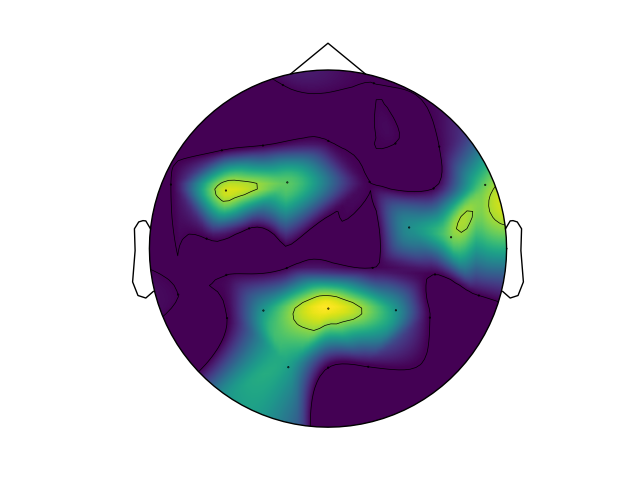

[0.         0.         0.         0.         0.         0.27739965
 0.21916237 0.         0.         0.         0.         0.
 0.29394565 0.15641546 0.         0.16689478 0.         0.
 0.15551481 0.         0.         0.         0.         0.14250154
 0.22636788 0.22152059 0.         0.         0.         0.
 0.        ]


In [57]:
# Extract the power values from the detected peaks
alpha_pw = alphas[:, 1]
# Plot the topography of alpha power
plt.figure()
plot_topomap(alpha_pw, signal_filtered_corrected.info, cmap=cm.viridis, contours=1)
print(alpha_pw)

<IPython.core.display.Javascript object>


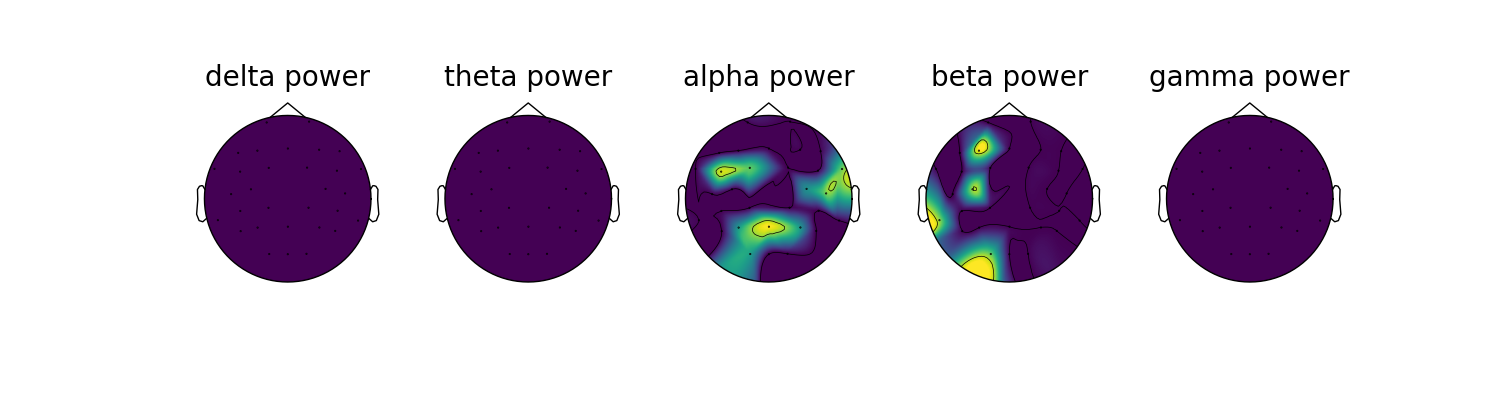

C:\Users\marta.castejon.SPAIN\Anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\marta.castejon.SPAIN\Anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\marta.castejon.SPAIN\Anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

In [58]:
# Plot the topographies across different frequency bands
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for ind, (label, band_def) in enumerate(bands):

    # Get the power values across channels for the current band
    band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
    band_power

    # Create a topomap for the current oscillation band
    mne.viz.plot_topomap(band_power, signal_filtered_corrected.info, cmap=cm.viridis, contours=1,
                         axes=axes[ind], show=False);

    # Set the plot title
    axes[ind].set_title(label + ' power', {'fontsize' : 20})